<a href="https://colab.research.google.com/github/pigeongcc/LogRegression_ElasticNet/blob/main/logistic_regression_elastic_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classic Logistic Regression & Elastic-Net

Моя реализация класса логистической регресии и elastic-net регрессии в рамках курса по глубокому обучению от МФТИ.

- Реализован класс логистической регрессии и унаследованный от него класс elastic-net регрессии (с измененной функцией расчета градиента).

- Для оптимизации моделей использован SGD. Реализован генератор батчей.

- Модели протестированы на искусственном датасете и датасете MNIST.

# Batch Generator

Обучение модели разделено на эпохи. Во время каждой эпохи модель будет обучена на каждом примере из обучающей выборки ровно один раз. Для этого нужно перемешаем строки в датасете и каждый раз будем брать очередные *batch_size* строчек.

Если размер датасета не делится нацело на *batch_size*, то последний батч не используется для обучения.

- *Input:* признаки, ответы и размер батча.

- *Output:* tuple из ($X_{batch}$, $y_{batch}$).
    - Если размер датасета не делится нацело на batch_size, последний батч не возвращается.


In [ ]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [ ]:
def generate_batches(X, y, batch_size):
    """
    param X: np.array[n_objects, n_features] --- матрица объекты-признаки
    param y: np.array[n_objects] --- вектор целевых переменных
    param batch_size: int --- размер одного батча
    """
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)

    perm = np.random.permutation(len(X))
    
    for batch_start in range(0, len(X), batch_size):
        batch_finish = batch_start + batch_size

        if(batch_finish > len(X)):
            return
        X_batch = [X[i] for i in perm[batch_start:batch_finish]]
        y_batch = [y[i] for i in perm[batch_start:batch_finish]]
        yield (np.asarray(X_batch), np.asarray(y_batch))
    


### Tests for Batch Generator

Проверяем:
1. Генератор батчей перемешал датасет.
2. Каждый элемент встречается ровно один раз

Кейс 1: размер датасета делится на размер батча.

In [ ]:
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

X_reconstructed, y_reconstructed = [], []
for X_batch, y_batch in generate_batches(X_fake, y_fake, 10):
    X_reconstructed.append(X_batch)
    y_reconstructed.append(y_batch)

X_reconstructed = np.concatenate(X_reconstructed)
y_reconstructed = np.concatenate(y_reconstructed)

assert (X_fake != X_reconstructed).all(), "Permutation of X failed: some rows are the same."
assert (y_fake != y_reconstructed).all(), "Permutation of y failed: some rows are the same."

assert (np.sort(X_reconstructed, axis=0) == X_fake).all(), "Some data from X is lost."

Кейс 2: размер датасета **не делится** на размер батча.

In [ ]:
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

num_batches = 0
for X_batch, y_batch in generate_batches(X_fake, y_fake, 7):
    num_batches += 1

assert num_batches == len(X_fake) // 7, "Error."

# Classic Logistic Regression

Класс, реализующий логистическую регрессию.

- Оптимизация с помощью SGD (использует генератор батчей, реализованный выше).
- Без регуляризации.


Функция потерь:

$$Loss(y, p) = -\sum_{i=1}^{l} (y_i \log (p_i) + (1 - y_i) \log (1 - p_i))$$

Производная функции потерь по весам:

$$ \frac{\partial L}{\partial w} = X^T (p - y)$$

In [ ]:
def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

In [ ]:
class MyLogisticRegression(object):
    def __init__(self):
        self.w = None
    
    def fit(self, X, y, epochs=10, lr=0.1, batch_size=100):
        n, k = X.shape

        if self.w is None:
            # Weights vector is a column vector
            self.w = np.random.randn(k + 1)

        # add the bias vector to the training set matrix
        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)
        
        # losses list will contain loss function values for each batch
        losses = []

        # fitting loop
        for i in range(epochs):
            for X_batch, y_batch in generate_batches(X_train, y, batch_size):
                # X_train already contains the bias (vector of 1s)

                # predict probabilities on X_batch
                predictions = self._predict_proba_internal(X_batch)
                # compute the loss on the current batch
                loss = self.__loss(y_batch, predictions)

                assert (np.array(loss).shape == tuple()), "Loss function value must be a scalar" 

                losses.append(loss)
                
                # update the weights using GD
                self.w -= lr * self.get_grad(X_batch, y_batch, predictions)

        return losses
    
    def get_grad(self, X_batch, y_batch, predictions):
        """
        param X_batch: np.array[batch_size, n_features + 1] --- матрица объекты-признаки (с уже добавленным столбцом единиц)
        param y_batch: np.array[batch_size] --- батч целевых переменных
        param predictions: np.array[batch_size] --- батч вероятностей классов

        returns: np.array[n_features + 1] --- a column vector of the loss function gradients for each weight.
        Each entry in this vector is the sum of the loss function gradients over each object in the batch.
        """
        
        grad_basic = np.transpose(X_batch) @ (predictions - y_batch)
        assert grad_basic.shape == (X_batch.shape[1],) , "Gradients must form a column vector of size (k_features + 1)"

        return grad_basic
        
    def predict_proba(self, X):
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))

    def _predict_proba_internal(self, X): 
        # This method doesn't concatenate X with the vector of 1s, as opposed to predict_proba.
        return sigmoid(logit(X, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold
    
    def get_weights(self):
        return self.w.copy()
      
    def __loss(self, y, p):  
        p = np.clip(p, 1e-10, 1 - 1e-10)

        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

### Tests for MyLogisticRegression class


In [ ]:
m = MyLogisticRegression()

X = np.array([[1, 3, 4], [1, -5, 6], [-3, 5, 3]])

y = np.array([1, 0, 1])
preds = np.array([.55, .22, .85])
m.fit(X, y)

X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
grads = m.get_grad(X, y, preds) 
assert np.allclose(grads, np.array([-0.38,  0.22, -3.2 , -0.93])), "Gradients are computed incorrectly."

In [ ]:
np.random.seed(42)
m = MyLogisticRegression()
X = np.random.rand(100,3)
y = np.random.randint(0, 1, size=(100,))
preds = np.random.rand(100)
grads = m.get_grad(X, y, preds) 
assert np.allclose(grads, np.array([23.8698149, 25.27049356, 24.4139452])), "Gradients are computed incorrectly."

# Elastic-Net
### Logistic Regression with $L_1$ and $L_2$ regularization

Реализация ElasticNet отличается от реализации MyLogisticRegression только функцией потерь для оптимизации. Поэтому единственная функция, которая будет отличаться у двух классов, - это ``self.get_grad()``.


Lasso ($L_1$) Regression:

$$L_1 (w) = \alpha \sum_{j=1}^{n}|w_j| $$

$$\frac{\partial L_1}{\partial w_1} = \alpha \cdot \mathrm{sign}(w_1)$$

Ridge ($L_2$) Regression:

$$L_2 (w) = \beta\sum_{j=1}^{n}w_j^2$$

$$ \frac{\partial L_2}{\partial w_1} = 2\beta w_1$$

($\alpha$, $\beta$ - regularization coefficients for Lasso and Ridge regression, respectively).

In [ ]:
class MyElasticLogisticRegression(MyLogisticRegression):
    def __init__(self, l1_coef, l2_coef):
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.w = None
    
    def get_grad(self, X_batch, y_batch, predictions):
        """
        param X_batch: np.array[batch_size, n_features + 1] --- матрица объекты-признаки (с уже добавленным столбцом единиц)
        param y_batch: np.array[batch_size] --- батч целевых переменных
        param predictions: np.array[batch_size] --- батч вероятностей классов

        returns: np.array[n_features + 1] --- a column vector of the loss function gradients for each weight.
        Each entry in this vector is the sum of the loss function gradients over each object in the batch.
        """
        # basic logistic regression gradient
        grad_basic = np.transpose(X_batch) @ (predictions - y_batch)

        # gradient component from l1-regularization
        grad_l1 = self.l1_coef * np.sign(self.w)
        grad_l1[0] = 0  # bias terms shouldn't be influenced by GD

        # gradient component from l2-regularization
        grad_l2 = 2 * self.l2_coef * self.w
        grad_l2[0] = 0  # bias terms shouldn't be influenced by GD
        
        assert grad_l1[0] == grad_l2[0] == 0, "Bias must not be included into regularization terms."
        assert grad_basic.shape == grad_l1.shape == grad_l2.shape == (X_batch.shape[1],), "Gradients must form a column vector of size (k_features + 1)"
        
        return grad_basic + grad_l1 + grad_l2

### Tests for Elastic-Net ``self.get_grad()`` function


In [ ]:
m = MyElasticLogisticRegression(.2,.2) 
X = np.array([[1, 3, 4], [1, -5, 6], [-3, 5, 3]])
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.array([1, 0, 1])
preds = np.array([.55, .22, .85])
m.w = np.array([1,1,1,1])
grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([-0.38,  0.82, -2.6 , -0.33])), "Gradients are computed incorrectly."

In [ ]:
np.random.seed(42)
m = MyElasticLogisticRegression(.2, .2)
X = np.random.rand(100,3)
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.random.randint(0, 1, size=(100,))
preds = np.random.rand(100)
m.w = np.array([1,1,1,1])
grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([49.11489408, 24.4698149, 25.87049356, 25.0139452])), "Gradients are computed incorrectly."

# Model Validation
Тестим модель на искусственных данных.

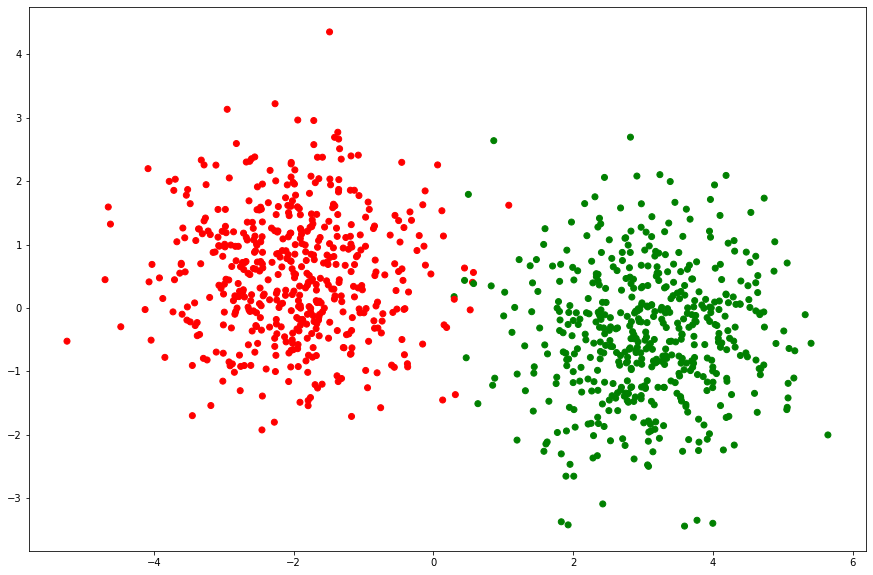

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[3,-0.5]], cluster_std=1, random_state=42)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y.ravel() == cl] = str(colors[i])
    
plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

## MyLogisticRegression

In [ ]:
lr_clf = MyLogisticRegression()
lr_clf.fit(X, y, epochs=1000)
w = lr_clf.get_weights()

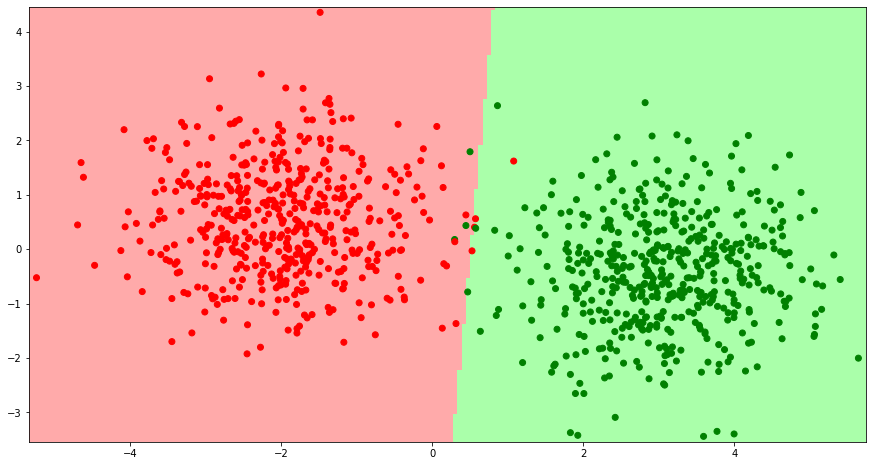

In [ ]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 200),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 200))
Z = lr_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)

## Elastic-Net Regression

In [ ]:
en_clf = MyElasticLogisticRegression(0.1, 0.1)
en_clf.fit(X, y, epochs=1000)
w = en_clf.get_weights()

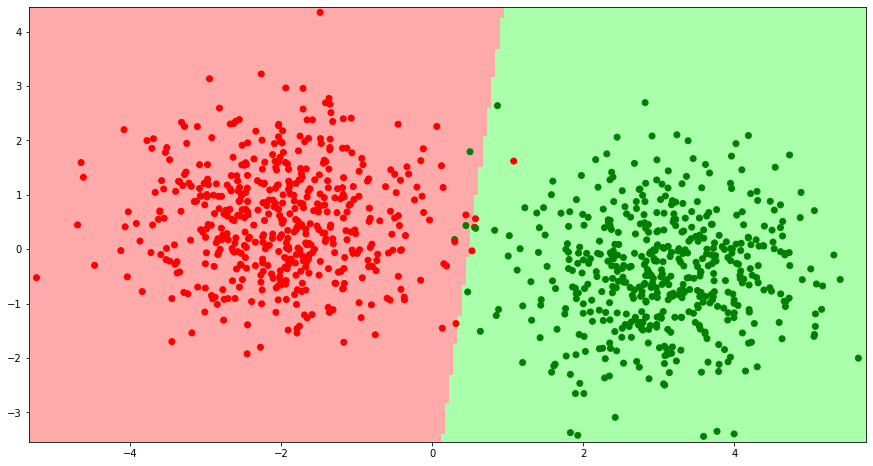

In [ ]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 200),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 200))
Z = en_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)

# MNIST Test

![mnist-3.0.1.png](https://www.researchgate.net/profile/Steven_Young11/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Адаптируем задачу под наш бинарный классификатор: выберем из всех картинок только 0 и 1 и обучим модель.

Датасет доступен для скачивания с моего гугл диска по ссылке: https://drive.google.com/file/d/1JbGLFqNxDS-oPy6uPf6WiSmZwoXXIaq_/view

In [ ]:
data = pd.read_csv('./MNIST_train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- Формат данных в датасете: таблица.
- Первый столбец - лейбл (цифра, которая изображена на картинке).
- Следующие 784 столбца - это значения от 0 до 255, описывающие все пиксели картинки 28х28.

In [ ]:
# Разделим таблицу на матрицу X и вектор y
X = data.iloc[:, 1:]
y = data.iloc[:, 1]

# Выберем картинки, содержащие только 0 или 1
X = X[(y == 0) | (y == 1)]
y = y[(y == 0) | (y == 1)]

Для оценки модели используем кросс-валидацию:

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# sklearn pipeline with StandarScaler and MyElasticLogisticRegression
cls = make_pipeline(
    StandardScaler(),
    MyElasticLogisticRegression(1, 1)
)
cls = cls.fit(X, y)
preds_train = cls.predict(X)

In [ ]:
# accuracy check via cross_val_score
mean_accuracy = np.mean(cross_val_score(cls, X, y, scoring='accuracy', cv=5))

print(f"Mean accuracy of Logistic Regression for two classes is {mean_accuracy}")

Mean accuracy of Logistic Regression for two classes is 0.9999523809523809
